In [1]:
import os
import glob

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import ParameterDict

import torchvision
from torchvision import transforms

import kornia as K

import matplotlib.pyplot as plt
from PIL import Image

from AugmentationsDataset import *

from utils import plot_tensor, show_sample, learning_grid, create_loss_map

In [2]:
### --- Config --- ###
augmentation_name = 'brightness'
main_parameter_name = 'brightness_factor'
aug_bounds = (0.0, 1.0)

# dataset
target_param_val = .5
target_aug_constructor = K.enhance.AdjustBrightness
target_aug_constructor_args = {
    'brightness_factor': target_param_val,
}

training_aug_constructor = K.enhance.AdjustBrightness
aug_learnable_params = {
    'brightness_factor': Parameter(torch.Tensor([0.0]))
}
training_aug_constructor_args = {}
aug_learnable_params_names = list(aug_learnable_params.keys())

# training
criterion_constructor = nn.MSELoss
criterion_constructor_args = {}

batch_size = 64
epochs = 1

optimizer_constructor = optim.SGD
optimizer_constructor_args = {
    'lr': 0.01,
    'momentum': 0.9,
}

scheduler_constructor = optim.lr_scheduler.CosineAnnealingLR
scheduler_constructor_args = {
    'T_max':100,
    'eta_min':0.1,
    'verbose':True,
}

scheduler_warmup = 100
scheduler_freq = 10
use_scheduler=False

early_stopping = 500

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# paths:
run_name = f'{augmentation_name}-init-{aug_learnable_params[main_parameter_name].item()}_target-{target_aug_constructor_args[main_parameter_name]}'

figures_dir = f'figures'
run_figures_dir = f'{figures_dir}/{run_name}'

gifs_dir = f'gifs'
run_gif_name = f'{gifs_dir}/{run_name}.gif'

os.makedirs(run_figures_dir, exist_ok=True)
os.makedirs(gifs_dir, exist_ok=True)
os.makedirs(f'{run_figures_dir}/results', exist_ok=True)

In [3]:
source_transform = transforms.Compose([
    transforms.ToTensor()
])

target_augmentations = transforms.Compose([
    K.augmentation.container.ImageSequential(
        target_aug_constructor(**target_aug_constructor_args)
    )
])

target_transform = transforms.Compose([
    transforms.ToTensor(),
    target_augmentations
])

In [4]:
glob_path = '../data/tiny-imagenet-200/train/*/images/*'
dataset = AugmentationsDataset(glob_path,
                               source_transform, target_transform,)

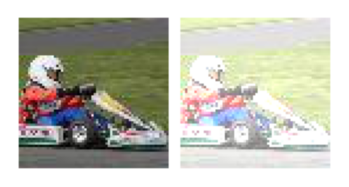

In [5]:
show_sample(dataset[0])

In [6]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

In [7]:
class AugmentationNetwork(nn.Module):
    def __init__(self, aug_constructor, learnable_params, aug_constructor_args, aug_bounds):
        super(AugmentationNetwork, self).__init__()
        self.aug_constructor = aug_constructor
        self.learnable_params = ParameterDict(learnable_params)
        self.aug_constructor_args = aug_constructor_args
        self.aug_bounds = aug_bounds
        
    def forward(self, x):
        learnable_clamped_params = {}
        for param_name in self.learnable_params:
            learnable_clamped_params[param_name] = torch.clamp(self.learnable_params[param_name],
                                                               min=self.aug_bounds[0],
                                                               max=self.aug_bounds[1])

        augmenter = K.augmentation.container.ImageSequential(
            self.aug_constructor(**learnable_clamped_params, **self.aug_constructor_args)
        )
        
        out = augmenter(x)
        return out

    

In [8]:
model = AugmentationNetwork(
    aug_constructor=training_aug_constructor,
    learnable_params=aug_learnable_params,
    aug_constructor_args=training_aug_constructor_args,
    aug_bounds=aug_bounds
)
model.to(device)

AugmentationNetwork(
  (learnable_params): ParameterDict(  (brightness_factor): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 0)])
)

In [9]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

learnable_params.brightness_factor tensor([0.], device='cuda:0')


In [10]:
criterion = criterion_constructor(**criterion_constructor_args)
optimizer = optimizer_constructor(model.parameters(), **optimizer_constructor_args)
scheduler = scheduler_constructor(optimizer, **scheduler_constructor_args)

Adjusting learning rate of group 0 to 1.0000e-02.


In [11]:
losses = []
lrs = []
p_progress = {p_name: [] for p_name in aug_learnable_params_names}
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(dataloader):
        source_images, target_images = data
        source_images, target_images = source_images.to(device), target_images.to(device)
        
        optimizer.zero_grad()

        output_images = model(source_images)
        loss = criterion(output_images, target_images)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        print_every = 10
        if i % print_every == print_every - 1:
            print(f'[Epoch: {epoch+1} | Batch: {i+1} | MSE Loss: {running_loss/print_every:.3f} | ', end='')
            print(f'{main_parameter_name}: {model.learnable_params[main_parameter_name].item()}]')
            running_loss = 0.0

            with torch.no_grad():
                img_dict = {
                    "source": dataset[0][0],
                    "model's output": model(dataset[0][0]).squeeze(),
                    "target": dataset[0][1]
                }
                learning_grid(img_dict, save=f'{run_figures_dir}/epoch-{epoch+1:02}_batch-{i+1:05}.png')
        
        lrs.append(scheduler.get_last_lr())
        for p_name in model.learnable_params:
            p_progress[p_name].append(model.learnable_params[p_name].item())
        if use_scheduler:
            if i % scheduler_freq == scheduler_freq - 1 and i > scheduler_warmup:
                scheduler.step()


        if i == early_stopping:
            break

print('Finished Training.')

[Epoch: 1 | Batch: 10 | MSE Loss: 0.122 | brightness_factor: 0.28667107224464417]
[Epoch: 1 | Batch: 20 | MSE Loss: 0.008 | brightness_factor: 0.5662920475006104]
[Epoch: 1 | Batch: 30 | MSE Loss: 0.006 | brightness_factor: 0.627225399017334]
[Epoch: 1 | Batch: 40 | MSE Loss: 0.006 | brightness_factor: 0.5788695812225342]
[Epoch: 1 | Batch: 50 | MSE Loss: 0.001 | brightness_factor: 0.5147189497947693]
[Epoch: 1 | Batch: 60 | MSE Loss: 0.000 | brightness_factor: 0.48306038975715637]
[Epoch: 1 | Batch: 70 | MSE Loss: 0.000 | brightness_factor: 0.48395437002182007]
[Epoch: 1 | Batch: 80 | MSE Loss: 0.000 | brightness_factor: 0.4956236481666565]
[Epoch: 1 | Batch: 90 | MSE Loss: 0.000 | brightness_factor: 0.5027781128883362]
[Epoch: 1 | Batch: 100 | MSE Loss: 0.000 | brightness_factor: 0.5033609867095947]
[Epoch: 1 | Batch: 110 | MSE Loss: 0.000 | brightness_factor: 0.5012394189834595]
[Epoch: 1 | Batch: 120 | MSE Loss: 0.000 | brightness_factor: 0.49963557720184326]
[Epoch: 1 | Batch: 130

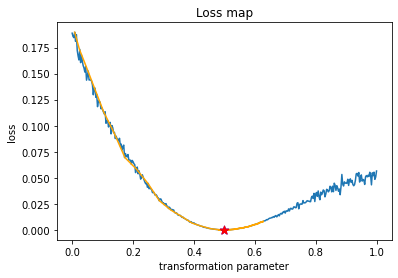

In [12]:
# loss map

param_linspace = np.linspace(aug_bounds[0],aug_bounds[1],361)
loss_map = create_loss_map(AugmentationNetwork, param_linspace,
                           dataloader, criterion,
                           save=run_name)
bound_p = lambda x: aug_bounds[0] if x < aug_bounds[0] else (aug_bounds[1] if x > aug_bounds[1] else x) # clamps p to aug_bounds
main_p_progress = p_progress[main_parameter_name]
main_p_progress = [bound_p(p) for p in main_p_progress]
main_p_progress_losses = [loss_map[np.argmin([abs(p-pg) for p in param_linspace])] for pg in main_p_progress]
final_param = main_p_progress[-1]
final_param = np.argmin([abs(p-final_param) for p in param_linspace])
statring_point = aug_learnable_params[main_parameter_name].item()
statring_point = np.argmin([abs(p-statring_point) for p in param_linspace])
plt.plot(param_linspace, loss_map, zorder=2)
plt.scatter(param_linspace[statring_point], y=[loss_map[statring_point]], marker='*', c='b', s=80, zorder=4)
plt.scatter(param_linspace[final_param], y=[loss_map[final_param]], marker='*', c='r', s=80, zorder=4)
plt.plot(main_p_progress, main_p_progress_losses, c='orange', zorder=3)
plt.title('Loss map')
plt.xlabel('transformation parameter')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/loss_map.png')

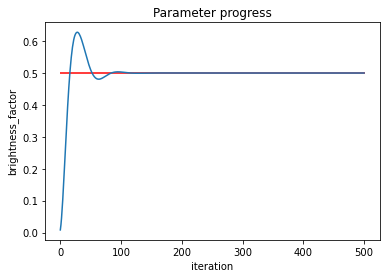

In [13]:
for p_name in p_progress:
    plt.plot(p_progress[p_name], zorder=7)
    plt.hlines(y=[target_aug_constructor_args[p_name]], xmin=[0], xmax=[len(p_progress[p_name])], color='r',zorder=5)
    plt.xlabel('iteration')
    plt.ylabel(f'{p_name}')
    plt.title('Parameter progress')
    plt.savefig(f'{run_figures_dir}/results/parameter_progress__{p_name}.png')

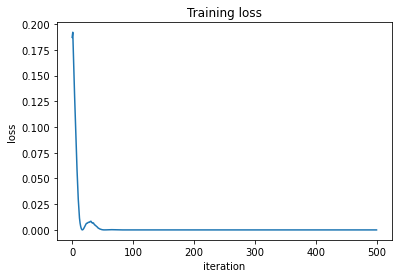

In [14]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.savefig(f'{run_figures_dir}/results/training_loss.png')

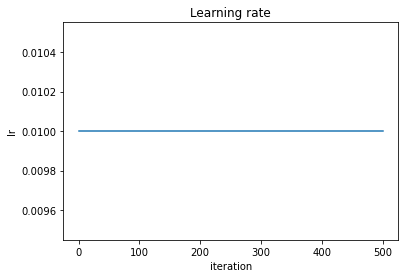

In [15]:
plt.plot(lrs)
plt.title('Learning rate')
plt.xlabel('iteration')
plt.ylabel('lr')
plt.savefig(f'{run_figures_dir}/results/learning_rate.png')

In [17]:
num_frames = 40
# filepaths
fp_in = f"{run_figures_dir}/epoch-*"
fp_out = run_gif_name

imgs = iter([Image.open(f) for f in sorted(glob.glob(fp_in))][:num_frames])
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=75, loop=0)